<h2 style="text-align: center"> Topic Modeling: Latent Dirichlet Allocation (LDA) </h2>

<img align="center" width="800" height="200" src="https://www.cdc.gov/coronavirus/2019-ncov/images/case-updates/math-models.jpg">

#### 1. Loading data
####  2. Data Cleaning
####  3. Phrase Modeling: Bi-grams and Tri-grams
####  4. Data transformation: Corpus and Dictionary
####  5. Base Model Performance
####  6. Hyperparameter Tuning
####  7. Final Model
####  8. Visualize Results

Reference:https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 

### Loading data

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
import tqdm

In [2]:
data = pd.read_csv('training_data.csv')

In [3]:
data.head()

,reviews.title,reviews.text,reviews.rating,reviews.date,reviews.userCity,reviews.userProvince,primaryCategories,categories,name,address,...,dimension,flavors,sizes,weight,colors,imageURLs,review.user_age,divisionName,departmentName,className
0,St Patrick Day Dash Hotel,We stayed at this hotel for the St Patrick's D...,4,2016-06-08T00:00:00.000Z,Seattle,Washington,Accommodation & Food Services,"Hotels and motels,Hotel South Lake Union,Hotel",Hyatt House Seattle/Downtown,201 5th Ave N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GREAT SPEAKERS,GREAT SPEAKERS FOR THE PRICE...GOT THEM ON SAL...,5,2013-01-20T00:00:00.000Z,NaN,NaN,Electronics,"Auto & Tires,Auto Electronics,Car Speakers and...","Alpine - 6-1/2"" 2-Way Coaxial Car Speakers wit...",NaN,...,NaN,NaN,NaN,5.2 pounds,NaN,https://i5.walmartimages.com/asr/e31a71ea-802e...,NaN,NaN,NaN,NaN
2,NaN,I love this jumpsuit! it runs a little large b...,4,NaN,NaN,NaN,Clothing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,General,Bottoms,Pants
3,Works great. Instructions were not clear that ...,Works great. Instructions were not clear that ...,5,NaN,NaN,NaN,Electronics,"Office,Office Technology,Phones & Accessories,...",Clarity - Super-Loud Phone Ringer - White,NaN,...,NaN,NaN,NaN,1.2 pounds,Cream,https://i5.walmartimages.com/asr/05e84e90-d193...,NaN,NaN,NaN,NaN
4,Fun place and great staff,Bad: Everything was great. Good: Superior expe...,5,2017-05-15T00:00:00.000Z,NaN,NaN,Accommodation & Food Services,"Hotels,Honeymoon Resorts,Resorts Reservations,...",Virgin Hotels Chicago,203 N Wabash Ave,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Loading data

In [4]:
df = data[['reviews.text','reviews.rating']].copy()

In [5]:
df.head()

,reviews.text,reviews.rating
0,We stayed at this hotel for the St Patrick's D...,4
1,GREAT SPEAKERS FOR THE PRICE...GOT THEM ON SAL...,5
2,I love this jumpsuit! it runs a little large b...,4
3,Works great. Instructions were not clear that ...,5
4,Bad: Everything was great. Good: Superior expe...,5


In [6]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df


In [7]:
df= standardize_text(df, "reviews.text")

In [8]:
df.head()

,reviews.text,reviews.rating
0,we stayed at this hotel for the st patrick's d...,4
1,great speakers for the price got them on sal...,5
2,i love this jumpsuit! it runs a little large b...,4
3,works great instructions were not clear that ...,5
4,bad everything was great good superior expe...,5


In [9]:
import gensim
from gensim import corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords


In [10]:
reviews = df['reviews.text'].to_list()

In [12]:
docs = [simple_preprocess(remove_stopwords(r)) for r in reviews]

In [14]:
review_dict = corpora.Dictionary(docs)

In [15]:
print(review_dict)

Dictionary(31531 unique tokens: ['actually', 'beware', 'blinds', 'breakfast', 'comments']...)


### Phrase Modeling: Bi-grams and Tri-grams

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
# prepare stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['it', 're', 've', 'didn'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(docs)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stay', 'nice', 'hotel', 'stay', 'suite', 'actually', 'kitchen', 'include', 'garbage', 'disposal', 'perfect', 'family', 'staying', 'day', 'room', 'face', 'room', 'open', 'blind', 'room', 'request', 'room', 'face', 'street', 'hotel', 'server', 'hot', 'breakfast', 'actually', 'pretty', 'good', 'supervised', 'good', 'went', 'second', 'hotel', 'parking', 'space', 'limit', 'small', 'leave', 'hotel', 'excellent', 'location', 'thank', 'take', 'time', 'pleasant', 'comment', 'downtown', 'ecstatic', 'hear', 'enjoy', 'room', 'morning', 'breakfast', 'spread', 'unbeatable', 'location', 'look', 'forward_hoste', 'future', 'happy', 'travel']]


### Data transformation: Corpus and Dictionary

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency (Bag of Words)
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 4), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 5), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


### Base Model

In [23]:
from gensim.models import LdaModel, LdaMulticore

In [24]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         random_state=100,
                         num_topics=10,
                         chunksize=100,
                         passes =10,
                         per_word_topics=True)

In [71]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"go" + 0.018*"tell" + 0.017*"check" + 0.015*"say" + 0.014*"get" + '
  '0.014*"time" + 0.014*"try" + 0.012*"ask" + 0.012*"day" + 0.011*"book"'),
 (1,
  '0.029*"dress" + 0.027*"size" + 0.026*"wear" + 0.024*"love" + 0.024*"look" + '
  '0.022*"fit" + 0.019*"color" + 0.015*"small" + 0.014*"great" + '
  '0.012*"order"'),
 (2,
  '0.046*"cheap" + 0.026*"bright" + 0.023*"drape" + 0.023*"surprise" + '
  '0.020*"coat" + 0.016*"stretchy" + 0.016*"snug" + 0.016*"carry" + '
  '0.014*"stylish" + 0.014*"download"'),
 (3,
  '0.034*"use" + 0.027*"easy" + 0.024*"work" + 0.021*"remote" + 0.020*"great" '
  '+ 0.017*"love" + 0.016*"buy" + 0.015*"device" + 0.012*"tv" + '
  '0.012*"tablet"'),
 (4,
  '0.029*"smell" + 0.028*"suit" + 0.026*"daughter" + 0.023*"back" + '
  '0.021*"cover" + 0.020*"gift" + 0.020*"carpet" + 0.019*"twice" + '
  '0.018*"construction" + 0.017*"terrible"'),
 (5,
  '0.047*"good" + 0.044*"sound" + 0.041*"great" + 0.035*"price" + '
  '0.024*"quality" + 0.023*"speaker" + 0.015*

In [72]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5233377359067427


### Hyperparameter Tuning

In [101]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [102]:
import numpy as np
# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = list(np.arange(min_topics, max_topics, step_size))
# Validation sets
model_results = {'Topics': [],'Coherence': []}


In [103]:
topics_range

[3, 4, 5, 6, 7, 8, 9, 10]

In [105]:
# Can take a long time to run
for k in topics_range:
    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus, dictionary=id2word, k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


In [123]:
result = pd.DataFrame.from_dict(model_results)

In [125]:
result

,Topics,Coherence
12,3,0.587489
13,4,0.529793
14,5,0.489277
15,6,0.486334
16,7,0.510611
17,8,0.473760
18,9,0.505343


Text(0.5, 0, 'Topic Numbers')

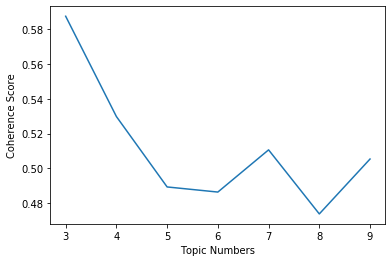

In [128]:
import matplotlib.pyplot as plt
plt.plot(result['Topics'], result['Coherence'])
plt.ylabel('Coherence Score')
plt.xlabel('Topic Numbers')

### Final Model (Bag-of-Words & Tf-idf)

In [129]:
#Bag-of-words
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=3, 
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        alpha=0.01,
                                        eta=0.9)

In [130]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (Topic Number = 3): ', coherence_lda)


Coherence Score (Topic Number = 3):  0.587662071755372


In [134]:
# Tf-idf
tfidf = models.TfidfModel(corpus)

In [136]:
lda_tfidf = LdaMulticore(corpus=tfidf[corpus],
                         id2word=id2word,
                         random_state=100,
                         num_topics=3,
                         chunksize=100,
                         passes=10,
                         per_word_topics=True)

In [140]:
coherence_model_lda_tfidf = CoherenceModel(model=lda_tfidf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('\nCoherence Score (Topic Number = 3): ', coherence_lda_tfidf)


Coherence Score (Topic Number = 3):  0.616455072567418


### Visualize Results

In [131]:
import pyLDAvis
import pyLDAvis.gensim

In [132]:
pyLDAvis.enable_notebook()

#### Bag-of-words

In [133]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.151991 -0.112246       1        1  47.163315
1     -0.204583 -0.043383       2        1  37.072628
2      0.052592  0.155629       3        1  15.764061, topic_info=        Term          Freq         Total Category  logprob  loglift
34      room  16515.000000  16515.000000  Default  30.0000  30.0000
40      stay  12532.000000  12532.000000  Default  29.0000  29.0000
19     hotel  12420.000000  12420.000000  Default  28.0000  28.0000
103    dress   8307.000000   8307.000000  Default  27.0000  27.0000
146     wear   7118.000000   7118.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
542  quality    741.150146   2632.943359   Topic3  -5.3282   0.5798
54       get    812.245850   4621.695312   Topic3  -5.2366   0.1087
568     want    723.871521   3474.218750   Topic3  -5.3518   0.2789
110      new    601.049988   1674.891357   Topic3  -5.5377   0.8226
159     come    561.862183   3181.524902   Topic3  -5.6051   0.1136

[209 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2255      1  0.002393     alexa
2255      2  0.002393     alexa
2255      3  0.995370     alexa
660       1  0.997966   amenity
660       2  0.001615   amenity
...     ...       ...       ...
2296      2  0.004727  wireless
2296      3  0.987857  wireless
69        1  0.249931      work
69        2  0.374150      work
69        3  0.376016      work

[501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

#### Tf-idf

In [139]:
vis = pyLDAvis.gensim.prepare(lda_tfidf,tfidf[corpus], dictionary=lda_tfidf.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.123755  0.163942       1        1  40.495655
1     -0.231167  0.007914       2        1  39.378498
2      0.107412 -0.171856       3        1  20.125851, topic_info=        Term        Freq       Total Category  logprob  loglift
34      room  880.000000  880.000000  Default  30.0000  30.0000
103    dress  814.000000  814.000000  Default  29.0000  29.0000
19     hotel  785.000000  785.000000  Default  28.0000  28.0000
40      stay  779.000000  779.000000  Default  27.0000  27.0000
85       use  462.000000  462.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
205     well  134.259140  383.102783   Topic3  -5.4859   0.5546
386  awesome  103.655685  184.169922   Topic3  -5.7446   1.0284
542  quality  117.504982  362.637756   Topic3  -5.6192   0.4762
285    light  108.102516  252.850037   Topic3  -5.7026   0.7534
526     need  115.077835  418.338318   Topic3  -5.6401   0.3125

[181 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2255      3  0.993632      alexa
470       3  0.995011        app
154       1  0.862328       area
154       2  0.138898       area
386       1  0.325786    awesome
...     ...       ...        ...
99        1  0.904855  wonderful
99        2  0.092806  wonderful
69        1  0.153459       work
69        2  0.341021       work
69        3  0.506416       work

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [141]:
import joblib
joblib.dump(lda_model, 'lda_model.pkl')
joblib.dump(lda_tfidf, 'lda_model_tfidf.pkl')

['lda_model_tfidf.pkl']